In [1]:
%config Completer.use_jedi = False

from IPython import display
import logging
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import layers, losses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture

seed = 1
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

In [3]:
# configs
latent_dim = 4096
batch_size = 32
channel = 2

# logger
logging.basicConfig(level = logging.INFO)

In [4]:
def preprocess_images(images,channel):
    #images=images[:,:,:,channel] # channel
    #images = images.reshape((images.shape[0], 32, 32,3, 1)) / 255.
    return images/255.
train_images = preprocess_images(train_images,channel)
test_images = preprocess_images(test_images,channel)

In [5]:
train_images.shape

(50000, 32, 32, 3)

In [6]:
class CAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CAE')
        self.encoder = tf.keras.Sequential(name='encoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(name='decoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8 * 8 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

        self.encoder.summary()
        self.decoder.summary()
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cae = CAE(latent_dim)
cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              8390656   
______________________________

In [7]:
cae.fit(x=train_images,y=train_images,validation_data=(test_images,test_images),epochs=10,\
        shuffle=True,batch_size=batch_size)

Epoch 1/10
1563/1563 [==============================] - 152s 97ms/step - loss: 0.0219 - val_loss: 0.0047
Epoch 2/10
1563/1563 [==============================] - 152s 97ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/10
1563/1563 [==============================] - 155s 99ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/10
1563/1563 [==============================] - 147s 94ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
1563/1563 [==============================] - 774s 496ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/10
1563/1563 [==============================] - 251s 160ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/10
1563/1563 [==============================] - 818s 524ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/10
1563/1563 [==============================] - 299s 191ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/10
1563/1563 [==============================] - 158s 101ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/10
1563/1563 [===========================

In [8]:
z = cae.encoder(test_images).numpy()
decoded_imgs = cae.decoder(z).numpy()

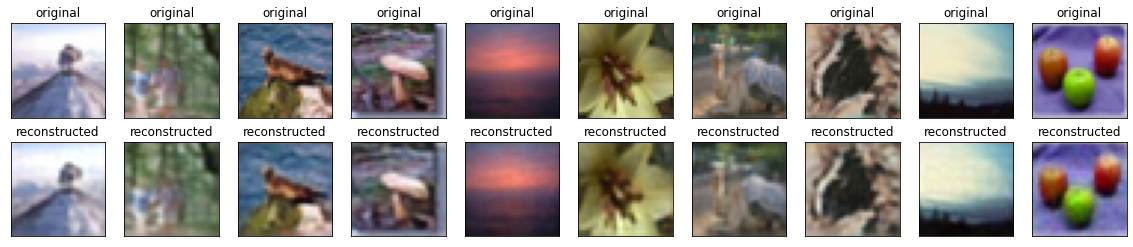

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
# def create_Gaussian_Mixture_Model(samples_tensor,k_list=[1,6,8,10,12]):
#     # todo work with k = 1
#     logger = logging.getLogger('create_Gaussian_Mixture_Model')
    
#     samples_np = samples_tensor.numpy()
#     min_aic,gm_min_aic = None,None
#     for k in k_list:
#         gm = GaussianMixture(n_components=k,covariance_type='diag').fit(samples_np)
#         gm_means = gm.means_
#         gm_cov = gm.covariances_
#         at_k_msg = f'At K = {k}'
#         logger.debug(f'{at_k_msg} - GM means = {gm_means}')
#         logger.debug(f'{at_k_msg} - GM cov = {gm_cov}')
#         aic = gm.aic(samples_np)
#         logger.debug(f'{at_k_msg} - GM AIC = {aic}')
#         logger.debug(f'{at_k_msg} - GM Weight {gm.weights_}')
#         if min_aic is None:
#             min_aic,gm_min_aic = aic,gm
#         elif aic < min_aic:
#             min_aic,gm_min_aic = aic,gm
#         logger.debug('------------------------------------')
    
#     # create tensorflow gm
#     dist_list = []
#     for i in range(len(gm_min_aic.means_)):
#         means_ = tf.convert_to_tensor(gm_min_aic.means_[i],dtype=tf.float64)
#         vars_ = tf.convert_to_tensor(gm_min_aic.covariances_[i],tf.float64)
#         mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=means_,scale_diag=vars_)
#         dist_list.append(mvn_diag)
#     tf_gm = tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=gm_min_aic.weights_)\
#                                       ,components=dist_list)
#     return tf_gm

In [15]:
def calc_z_likelihood(z,raxis = 0):
    
    n = len(z)
    n_train = int(0.8*n)
    z_train = z[:n_train]
    z_test = z[n_train:]
    logger = logging.getLogger('calc_z_likelihood')
    min_aic = None
    gm_fit_min_aic = None
    for k in range(2,11):

        gm_fit = GaussianMixture(n_components=k,covariance_type='diag').fit(z_train)
        aic_ = gm_fit.aic(z_test)
        logger.info(f'Built GM model with k = {k} and test aic = {aic_}')
        if min_aic is None:
            min_aic = aic_
            gm_fit_min_aic = gm_fit
        elif aic_ < min_aic:
            min_aic = min(aic_,min_aic)
            gm_fit_min_aic = gm_fit
    logger.info(f'best gm model with k = {len(gm_fit_min_aic.means_)} and test aic = {min_aic}')
    g_fit = GaussianMixture(n_components=1,covariance_type='diag').fit(z_train) # gaussian
    
    logp_dict = dict()
    logp_dict['GM_diag'] = np.nansum(gm_fit.score_samples(z_test))
    logp_dict['Gaus_diag'] = np.nansum(g_fit.score_samples(z_test))
    
    """
    
    sample_mean = tf.reduce_max(input_tensor=z_train,axis=raxis)
    sample_cov = tfp.stats.covariance(x=z_train)

    
    sample_var = tf.linalg.diag_part(input=sample_cov)+0.1

    mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=sample_mean,scale_diag=sample_var)
    
    logger.debug(f'Gaus Diag sample mean = {sample_mean}')
    logger.debug(f'Gaus Diag sample cov = {sample_cov}')
    
    #mvn_tri = tfp.distributions.MultivariateNormalTriL(loc=sample_mean,scale_tril=L)
    log_p_diag = tf.reduce_sum(mvn_diag.log_prob(z_test))
    
    # calculate GM model
    gm_diag = create_Gaussian_Mixture_Model(samples_tensor=z_test)
    log_p_gm_diag = tf.reduce_sum(gm_diag.log_prob(tf.cast(x=z,dtype=tf.float64)))
    
    #logger.debug(f'log_p_gm_diag = {log_p_gm_diag}')
    
    logp_dict['GM_diag'] = log_p_gm_diag
    logp_dict['Gaus_diag'] = log_p_diag
    
    """
    
    return logp_dict

INFO:Main:Training autoencoder for label 0


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


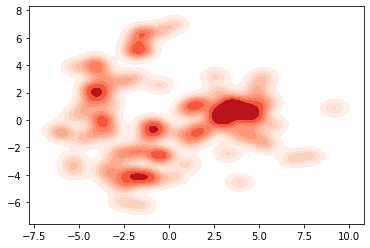

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -117513.62343324997
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -103198.53910817226
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -81666.20875048728
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -71891.38550620968
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -54520.38707800704
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -33190.13426873248
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -13464.828448921733
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 8019.755744470662
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 21199.33403090792
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -117513.62343324997
INFO:Main:For label 0 log_p_gm_diag = 71329.33298454604
INFO:Main:For label 0 log_p_gaus_diag = 66241.02183439283
INFO:Main:For label 0 rel_diff =         0.07681511
IN

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_15 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


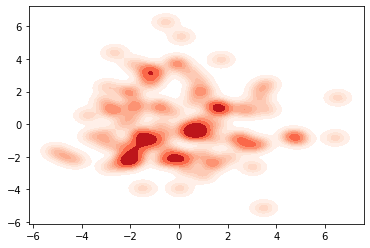

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -142263.72803842838
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -128545.31260423083
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -109739.12441975926
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -94629.11090622813
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -76169.10828370592
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -60306.85420988462
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -39187.00928440929
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -21611.900837228226
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -4399.839813499188
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -142263.72803842838
INFO:Main:For label 1 log_p_gm_diag = 84128.9199067496
INFO:Main:For label 1 log_p_gaus_diag = 85207.20115667897
INFO:Main:For label 1 rel_diff =         -0.01265481

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_16 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


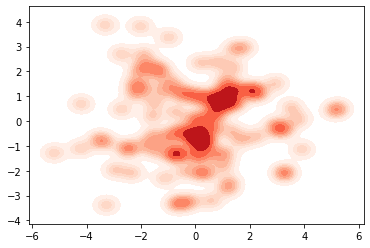

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -163882.2333811906
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -145192.50523454105
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -131980.99418240858
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -112553.2751040163
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -100634.65202509507
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -75969.4828880615
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -57493.97411369707
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -41436.22811442084
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -20299.790898329957
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -163882.2333811906
INFO:Main:For label 2 log_p_gm_diag = 92078.89544916498
INFO:Main:For label 2 log_p_gaus_diag = 95920.69109502962
INFO:Main:For label 2 rel_diff =         -0.04005179


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_17 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


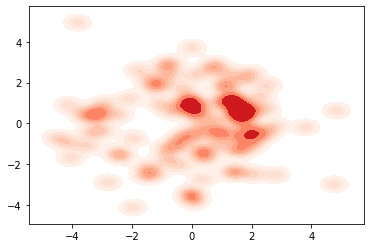

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -143063.96292795968
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -126695.34431105675
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -104141.6847871893
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -85655.7429843331
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -70499.98223483615
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -49679.997123119596
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -28898.343281044014
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -14234.450214433164
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 3862.500629067188
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -143063.96292795968
INFO:Main:For label 3 log_p_gm_diag = 79997.7496854664
INFO:Main:For label 3 log_p_gaus_diag = 85892.13635538048
INFO:Main:For label 3 rel_diff =         -0.06862545


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_18 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


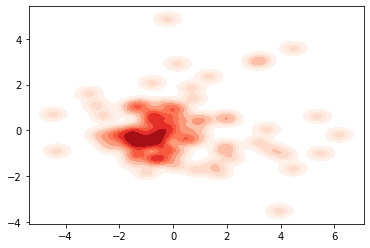

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -202672.73267237563
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -186619.53527564098
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -163122.50809070954
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -149261.43526715765
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -132191.3673501848
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -111668.2428775937
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -88371.83637945796
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -74636.9878982784
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -50674.15034585615
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -202672.73267237563
INFO:Main:For label 4 log_p_gm_diag = 107266.07517292807
INFO:Main:For label 4 log_p_gaus_diag = 113199.58190983906
INFO:Main:For label 4 rel_diff =         -0.052416

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_19 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


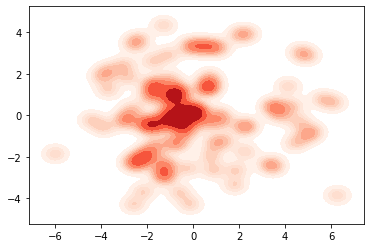

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -141219.0220486555
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -124222.63892032439
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -107930.68144257262
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -94037.59205283975
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -72255.71844551156
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -55804.27784869983
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -42298.771528058685
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -17438.94664279645
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 3345.0932983923994
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -141219.0220486555
INFO:Main:For label 5 log_p_gm_diag = 80256.4533508038
INFO:Main:For label 5 log_p_gaus_diag = 85015.70794771507
INFO:Main:For label 5 rel_diff =         -0.05598089
I

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_20 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


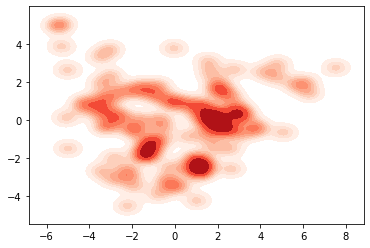

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -138887.01288559934
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -121865.54835350486
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -109348.67697163153
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -86700.92078419152
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -72572.94841352961
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -57937.790062215296
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -34983.30033032817
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -20020.530532828416
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -342.98752095992677
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -138887.01288559934
INFO:Main:For label 6 log_p_gm_diag = 82100.49376047996
INFO:Main:For label 6 log_p_gaus_diag = 82188.70849098965
INFO:Main:For label 6 rel_diff =         -0.00107

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_21 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


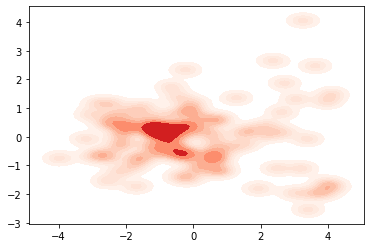

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -230280.2936474894
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -213832.422145986
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -202403.9057047977
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -184077.4210487295
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -165202.55981791572
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -144961.09110954843
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -121464.44916533813
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -105470.99638515856
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -92155.9716924639
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -230280.2936474894
INFO:Main:For label 7 log_p_gm_diag = 128006.98584623194
INFO:Main:For label 7 log_p_gaus_diag = 124025.74920958906
INFO:Main:For label 7 rel_diff =         0.03210008


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_22 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


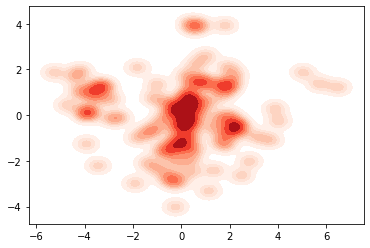

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -173796.33462889036
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -162710.1323661678
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -143885.3026281872
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -128510.27293324814
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -109874.01888113085
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -95096.05978448063
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -72414.71287344815
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -50503.57459117321
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -42145.0093960017
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -173796.33462889036
INFO:Main:For label 8 log_p_gm_diag = 103001.50469800085
INFO:Main:For label 8 log_p_gaus_diag = 98045.97200654763
INFO:Main:For label 8 rel_diff =         0.05054295


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_23 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


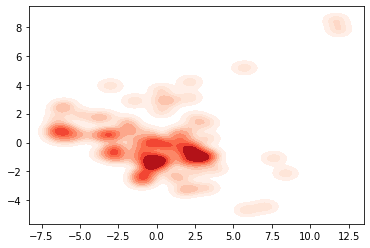

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -122233.19770026344
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -117805.27146828792
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -91818.02747959137
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -89622.92308107283
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -69557.2718299083
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -54063.39088579925
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 646.2052572214452
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 8780.294576501125
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 34174.627943438376
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -122233.19770026344
INFO:Main:For label 9 log_p_gm_diag = 64841.68602828081
INFO:Main:For label 9 log_p_gaus_diag = 74266.91191181583
INFO:Main:For label 9 rel_diff =         -0.12691016
INF

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_24 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


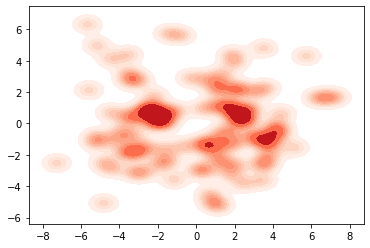

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -117685.20957553899
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -103571.17962704814
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -86851.26118928468
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -63738.98296237434
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -45539.0218373941
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -24955.98858773033
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 238.27656350986217
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 11581.457614350133
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 28989.206692456413
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -117685.20957553899
INFO:Main:For label 10 log_p_gm_diag = 67434.3966537718
INFO:Main:For label 10 log_p_gaus_diag = 70506.699109851
INFO:Main:For label 10 rel_diff =         -0.04357462
I

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_25 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


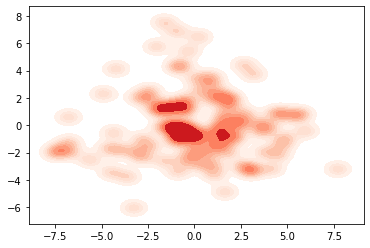

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -108105.15217837488
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -93808.36888319263
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -74928.37241723898
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -61557.06792945121
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -39148.113925712154
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -23079.744270365656
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -2696.8006702768325
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 13319.446859456948
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 31463.19533910521
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -108105.15217837488
INFO:Main:For label 11 log_p_gm_diag = 66197.4023304474
INFO:Main:For label 11 log_p_gaus_diag = 65349.309369408795
INFO:Main:For label 11 rel_diff =         0.012977

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_26 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


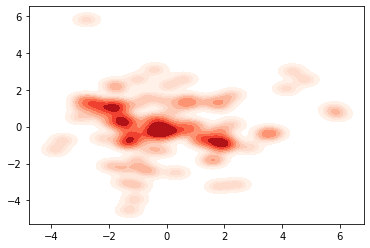

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -156781.42221798774
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -139689.84997520916
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -121273.37096346094
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -102774.63096352562
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -83493.08118078369
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -68477.15869158687
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -48580.78002165159
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -32286.329894300026
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -19126.996446794772
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -156781.42221798774
INFO:Main:For label 12 log_p_gm_diag = 91492.49822339739
INFO:Main:For label 12 log_p_gaus_diag = 91856.32264335689
INFO:Main:For label 12 rel_diff =         -0.00

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_27 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


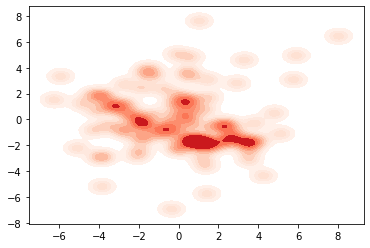

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -78545.05105141549
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -66389.52661216524
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -49643.99523208145
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -31423.537550166075
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -12513.92762941694
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -384.8259436832159
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 28580.914709382705
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 42830.88672132717
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 59744.97493231694
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -78545.05105141549
INFO:Main:For label 13 log_p_gm_diag = 52056.51253384153
INFO:Main:For label 13 log_p_gaus_diag = 55556.870387595605
INFO:Main:For label 13 rel_diff =         -0.06300495


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_28 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


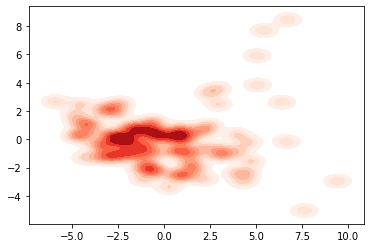

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -110824.63947793611
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -95284.57103573592
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -77195.88710729714
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -54305.068319614686
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -40310.91293281445
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -17060.47604448354
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -2649.6120164961903
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 10304.54572400471
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 33503.5675141713
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -110824.63947793611
INFO:Main:For label 14 log_p_gm_diag = 65177.21624291435
INFO:Main:For label 14 log_p_gaus_diag = 67323.41151046334
INFO:Main:For label 14 rel_diff =         -0.03187888

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_29 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


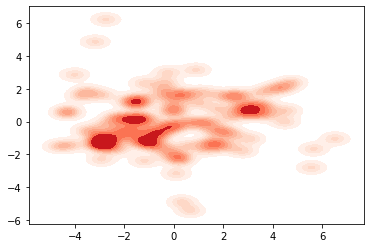

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -143612.76650943066
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -129943.23132324079
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -109676.30751082575
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -97107.34174583908
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -77035.79675690905
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -59176.413652316434
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -45735.192307768826
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -28465.86751685894
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -6011.344682909577
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -143612.76650943066
INFO:Main:For label 15 log_p_gm_diag = 84934.67234145479
INFO:Main:For label 15 log_p_gaus_diag = 85739.63224492906
INFO:Main:For label 15 rel_diff =         -0.009

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_30 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


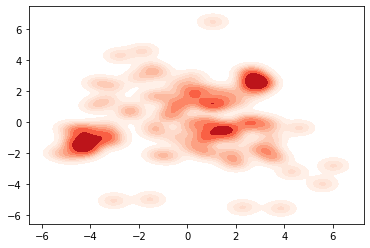

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -142295.9867056313
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -126383.50100660825
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -120524.51354012336
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -103577.01427100878
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -89653.81854284654
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -65213.93543404114
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -45161.08822034439
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -26439.706782196357
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -11068.883926598064
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -142295.9867056313
INFO:Main:For label 16 log_p_gm_diag = 87463.44196329903
INFO:Main:For label 16 log_p_gaus_diag = 79488.98014481591
INFO:Main:For label 16 rel_diff =         0.10032

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_31 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


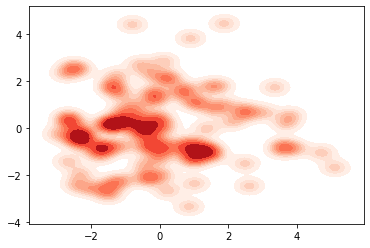

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -178270.2690328468
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -162201.72474403953
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -146099.59395269555
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -129413.58489836365
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -110068.04049596342
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -95124.44225044409
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -76230.06427254662
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -53180.60747207701
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -41534.47446476156
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -178270.2690328468
INFO:Main:For label 17 log_p_gm_diag = 102696.23723238076
INFO:Main:For label 17 log_p_gaus_diag = 102146.82479196061
INFO:Main:For label 17 rel_diff =         0.0053

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_32 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


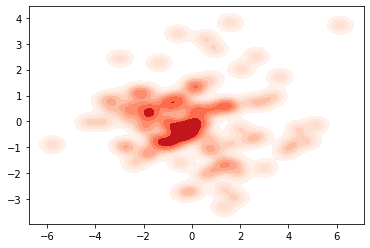

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -169931.547438304
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -149735.3579336821
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -133515.01159418054
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -116741.45651919878
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -100074.37346327631
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -81852.95392882085
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -65429.858805681404
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -39456.42264120764
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -33437.92670926434
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -169931.547438304
INFO:Main:For label 18 log_p_gm_diag = 98647.96335463217
INFO:Main:For label 18 log_p_gaus_diag = 99058.80236437787
INFO:Main:For label 18 rel_diff =         -0.0041474

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_33 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


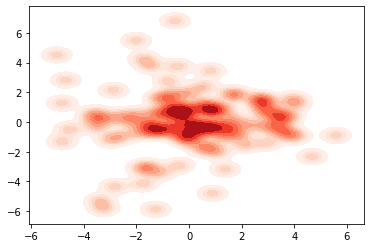

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -122095.7142347082
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -104795.94459874617
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -89900.94770182561
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -72124.90449060005
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -54878.18099317787
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -33828.23087742223
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -15580.910051469662
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 6626.042162887665
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 23110.82481117401
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -122095.7142347082
INFO:Main:For label 19 log_p_gm_diag = 70373.587594413
INFO:Main:For label 19 log_p_gaus_diag = 75726.23519271784
INFO:Main:For label 19 rel_diff =         -0.07068419
IN

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_34 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


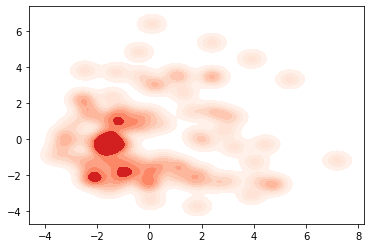

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -143197.8967324142
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -121311.15803780445
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -108366.39404855057
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -89399.93036186238
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -73790.81473036512
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -53310.09353852749
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -30764.70192019985
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -14086.19597389971
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 14321.368901557202
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -143197.8967324142
INFO:Main:For label 20 log_p_gm_diag = 74768.3155492214
INFO:Main:For label 20 log_p_gaus_diag = 83176.99627263924
INFO:Main:For label 20 rel_diff =         -0.10109383

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_35 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


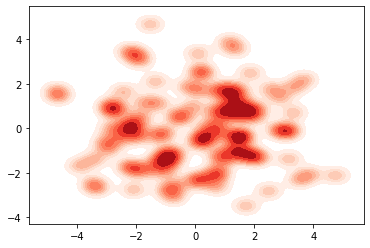

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -139532.30970583504
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -122519.29767891706
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -105819.91194919136
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -86954.55794173741
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -68878.7041553747
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -53453.58078462622
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -35728.37131479388
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -14467.795489103126
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -1679.5813582772098
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -139532.30970583504
INFO:Main:For label 21 log_p_gm_diag = 82768.7906791386
INFO:Main:For label 21 log_p_gaus_diag = 83704.02806789533
INFO:Main:For label 21 rel_diff =         -0.01117

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_36 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


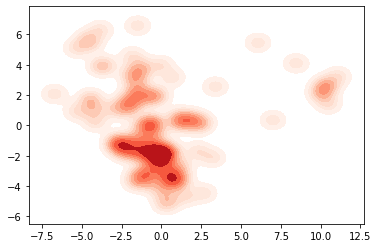

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -128495.65423453136
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -126094.10426670077
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -111722.30103351333
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -93345.19842575298
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -76517.66346486914
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -51460.6267912286
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -41738.614486165636
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -20735.590476690908
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -2091.693888297421
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -128495.65423453136
INFO:Main:For label 22 log_p_gm_diag = 82974.8469441487
INFO:Main:For label 22 log_p_gaus_diag = 69563.18180160083
INFO:Main:For label 22 rel_diff =         0.192798

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_37 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


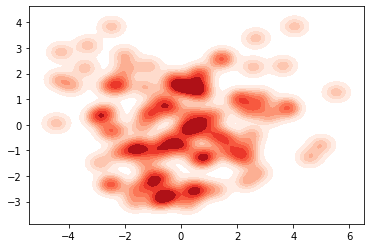

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -195115.4518746643
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -186525.37479277953
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -167011.4928281213
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -153794.04834289124
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -131199.95384911363
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -115275.98757278454
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -89996.88743903831
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -77386.96281494654
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -56443.04430513043
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -195115.4518746643
INFO:Main:For label 23 log_p_gm_diag = 110150.52215256522
INFO:Main:For label 23 log_p_gaus_diag = 110034.66614480728
INFO:Main:For label 23 rel_diff =         0.0010

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_38 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


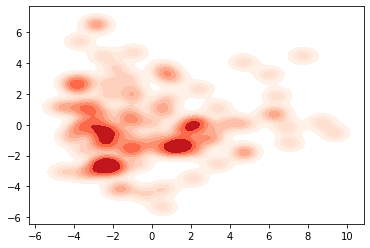

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -107037.91820779312
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -92518.68030517199
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -73237.16158976126
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -62304.588615576795
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -39885.36626968952
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -20495.526706007775
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 1757.1890624292137
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 13168.068256194412
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 32892.21337493842
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -107037.91820779312
INFO:Main:For label 24 log_p_gm_diag = 65482.89331253079
INFO:Main:For label 24 log_p_gaus_diag = 62159.44078465218
INFO:Main:For label 24 rel_diff =         0.0534665

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_39 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


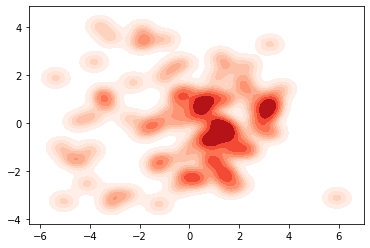

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -165597.55531020928
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -155990.41823410548
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -141088.9754522476
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -121375.7025937424
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -98403.42059051676
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -81331.05342890974
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -63097.06387846754
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -43755.10523988123
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -24974.871718114184
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -165597.55531020928
INFO:Main:For label 25 log_p_gm_diag = 94416.43585905709
INFO:Main:For label 25 log_p_gaus_diag = 92952.77313887363
INFO:Main:For label 25 rel_diff =         0.015746

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_40 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


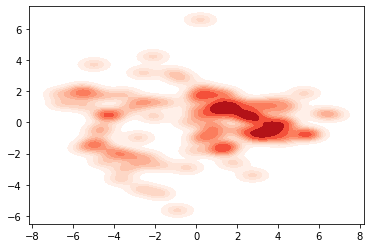

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -145652.61802865865
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -129079.75560169213
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -107414.67686792288
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -94796.94840882038
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -71209.31054098107
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -53260.21926793002
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -42456.319701408036
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -15506.975299069483
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 8185.981850655371
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -145652.61802865865
INFO:Main:For label 26 log_p_gm_diag = 77836.00907467231
INFO:Main:For label 26 log_p_gaus_diag = 81276.47265182926
INFO:Main:For label 26 rel_diff =         -0.0423

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_41 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


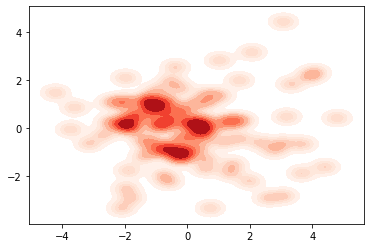

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -171868.2697690598
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -151484.02912689792
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -137541.24496606947
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -118614.88525110309
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -102176.16759902285
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -87624.36472163588
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -66843.9716683914
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -45374.67654679285
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -32388.691623327264
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -171868.2697690598
INFO:Main:For label 27 log_p_gm_diag = 98123.34581166363
INFO:Main:For label 27 log_p_gaus_diag = 99753.90041127597
INFO:Main:For label 27 rel_diff =         -0.01634

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_42 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_84 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


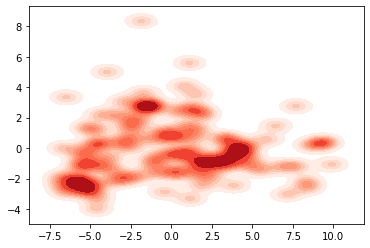

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -130340.7437957424
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -127521.06356431189
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -108341.25248803897
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -95361.60961523227
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -80595.8575465407
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -53659.37961728056
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -40031.880362245254
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -17763.8929130091
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -7558.04473909369
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -130340.7437957424
INFO:Main:For label 28 log_p_gm_diag = 85708.02236954684
INFO:Main:For label 28 log_p_gaus_diag = 74621.79433303818
INFO:Main:For label 28 rel_diff =         0.14856555
I

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_43 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


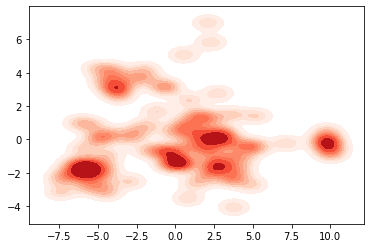

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -124064.52878057744
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -115621.01724306683
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -105845.91348250222
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -87009.09140727555
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -67886.7602701289
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -56753.493536695605
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -31306.200591851375
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -22594.572996519215
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -2474.3770622941374
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -124064.52878057744
INFO:Main:For label 29 log_p_gm_diag = 83166.18853114707
INFO:Main:For label 29 log_p_gaus_diag = 68869.55927123746
INFO:Main:For label 29 rel_diff =         0.207

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_44 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


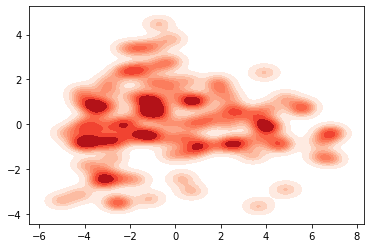

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -195546.31809629718
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -186158.74087684334
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -169208.10254563054
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -153953.22153738752
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -134008.5941284781
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -117267.22224500004
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -95775.94824924343
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -83673.50434486102
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -52192.887406312744
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -195546.31809629718
INFO:Main:For label 30 log_p_gm_diag = 108025.44370315639
INFO:Main:For label 30 log_p_gaus_diag = 103737.04690755953
INFO:Main:For label 30 rel_diff =         0.0

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_45 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


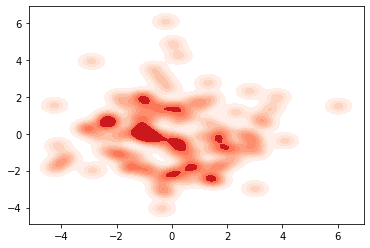

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -146784.61963623232
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -130229.55130212731
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -113806.20752000809
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -102983.2152440142
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -80117.10184817825
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -59167.71683021297
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -51325.19824131986
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -23422.740917698888
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -8916.936627748306
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -146784.61963623232
INFO:Main:For label 31 log_p_gm_diag = 86387.46831387417
INFO:Main:For label 31 log_p_gaus_diag = 89377.07960487442
INFO:Main:For label 31 rel_diff =         -0.0334

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_46 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


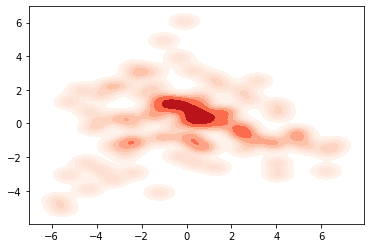

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -127763.25383295762
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -108339.14123991993
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -89288.51882066063
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -78474.68507322096
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -56432.371032071474
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -42281.605119348125
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -21239.131721480342
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -677.0016191358154
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 11814.946029549435
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -127763.25383295762
INFO:Main:For label 32 log_p_gm_diag = 76021.52698522528
INFO:Main:For label 32 log_p_gaus_diag = 78173.95967467614
INFO:Main:For label 32 rel_diff =         -0.027

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_47 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


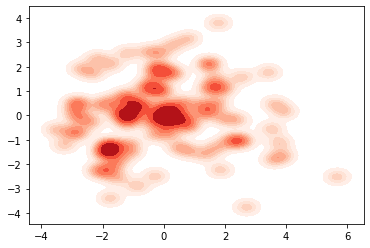

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -181066.58438603603
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -167730.21387008863
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -151143.270605747
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -133863.32058975182
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -117928.17166565004
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -89942.7306530212
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -77286.81157865096
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -61930.58727852153
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -39246.41470539346
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -181066.58438603603
INFO:Main:For label 33 log_p_gm_diag = 101552.20735269673
INFO:Main:For label 33 log_p_gaus_diag = 103558.15741642674
INFO:Main:For label 33 rel_diff =         -0.0193

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_48 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


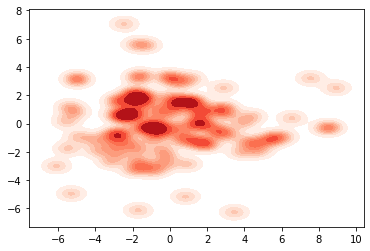

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -105756.25091295285
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -88984.76768356425
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -75241.33966398411
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -57853.49487288701
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -36498.098813621415
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -17818.93314145613
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 3397.07407308447
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 24995.870602970783
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 47002.76421231023
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -105756.25091295285
INFO:Main:For label 34 log_p_gm_diag = 58427.61789384489
INFO:Main:For label 34 log_p_gaus_diag = 64444.68816464644
INFO:Main:For label 34 rel_diff =         -0.09336798


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_49 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


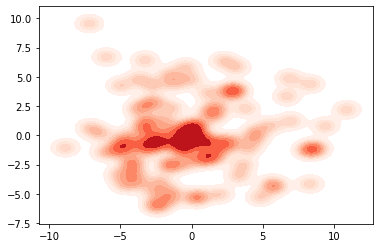

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -74867.72161648855
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -56261.7854866546
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -42255.573012683104
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -23019.2763992275
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = 99.00526615718263
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = 18663.385628523713
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 35240.3979579095
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 46623.09688939279
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 74374.00165765644
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -74867.72161648855
INFO:Main:For label 35 log_p_gm_diag = 44741.99917117178
INFO:Main:For label 35 log_p_gaus_diag = 48836.4311563937
INFO:Main:For label 35 rel_diff =         -0.08383971
INFO:Ma

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_50 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


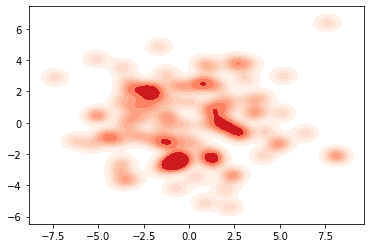

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -110610.44846247637
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -92343.35901333601
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -71827.26937826962
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -55744.763376202114
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -40317.43438441536
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -12230.936412748822
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 524.5520908209728
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 16022.899313891772
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 42179.88826701627
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -110610.44846247637
INFO:Main:For label 36 log_p_gm_diag = 60839.055866491864
INFO:Main:For label 36 log_p_gaus_diag = 67845.09908686324
INFO:Main:For label 36 rel_diff =         -0.103265

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_51 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


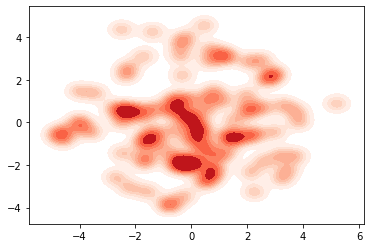

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -123304.81849623992
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -107477.83505733314
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -85577.50722850952
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -64584.53130457373
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -47692.950084455486
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -25650.797823323344
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -11959.835001878324
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 8394.794129329908
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 29981.967413493927
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -123304.81849623992
INFO:Main:For label 37 log_p_gm_diag = 66938.01629325304
INFO:Main:For label 37 log_p_gaus_diag = 77403.17360978058
INFO:Main:For label 37 rel_diff =         -0.1352

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_52 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


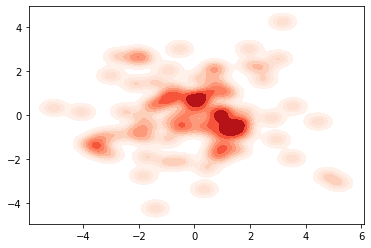

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -151740.20447026775
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -133575.87218128197
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -114604.56817930902
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -100077.73819512891
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -76493.10234980972
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -64440.190688278875
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -39485.315765217645
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -20148.845848602417
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -1040.9439556362922
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -151740.20447026775
INFO:Main:For label 38 log_p_gm_diag = 82449.47197781815
INFO:Main:For label 38 log_p_gaus_diag = 87861.20988471467
INFO:Main:For label 38 rel_diff =         -0.

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_53 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


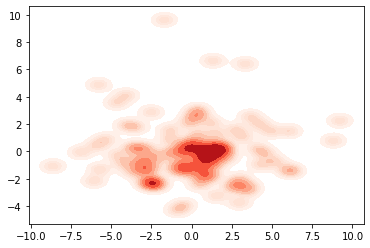

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -113668.21627784983
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -101108.1518677687
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -78820.37566984195
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -60050.81674687314
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -45741.24754005007
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -30859.627684453095
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -5633.461263019708
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 10570.101330644422
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 30668.85582001548
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -113668.21627784983
INFO:Main:For label 39 log_p_gm_diag = 66594.57208999226
INFO:Main:For label 39 log_p_gaus_diag = 67088.01086283664
INFO:Main:For label 39 rel_diff =         -0.0073551

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_54 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_108 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


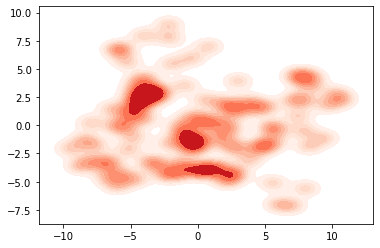

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -59094.803543858754
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -44116.620869920385
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -25903.331887324166
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -14214.664480404128
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = 14553.174434331915
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = 36179.86834469397
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 64341.05522657045
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 73180.28149346173
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 93449.39836765711
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -59094.803543858754
INFO:Main:For label 40 log_p_gm_diag = 35204.300816171446
INFO:Main:For label 40 log_p_gaus_diag = 42804.396925033194
INFO:Main:For label 40 rel_diff =         -0.177554

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_55 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


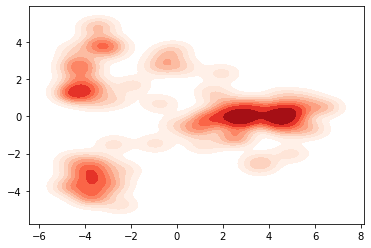

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -154221.95565741195
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -139474.55565936785
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -130127.40563537984
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -109871.1445484591
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -95109.31581601617
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -76180.23355846529
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -56586.138123056735
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -29012.207798060204
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -6498.654842741293
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -154221.95565741195
INFO:Main:For label 41 log_p_gm_diag = 85178.32742137065
INFO:Main:For label 41 log_p_gaus_diag = 83038.57018115066
INFO:Main:For label 41 rel_diff =         0.0257

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_56 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


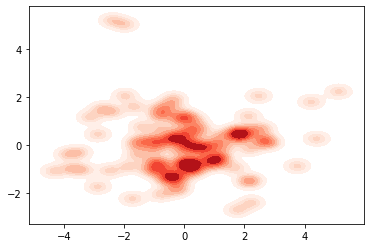

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -194821.22101578946
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -180385.1520514362
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -164208.44209556398
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -146756.88450050348
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -131387.69883209877
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -111046.78804315266
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -95615.97682964243
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -65136.418495135295
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -52255.309857738146
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -194821.22101578946
INFO:Main:For label 42 log_p_gm_diag = 108056.65492886907
INFO:Main:For label 42 log_p_gaus_diag = 112792.17936660597
INFO:Main:For label 42 rel_diff =         -0

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_57 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


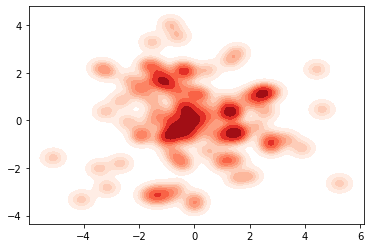

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -153413.38963667394
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -142795.73109741916
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -123054.22046393095
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -102572.45312618779
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -83627.43468193611
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -70447.00414566821
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -50236.08017027157
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -21435.30626030627
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -11102.087883314758
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -153413.38963667394
INFO:Main:For label 43 log_p_gm_diag = 87480.04394165738
INFO:Main:For label 43 log_p_gaus_diag = 93331.2796498352
INFO:Main:For label 43 rel_diff =         -0.0626

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_58 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_116 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


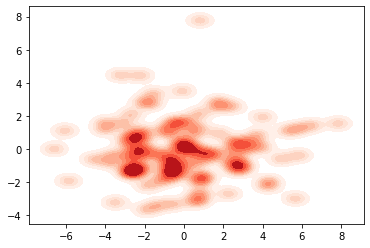

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -125283.1257446674
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -107277.8026087188
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -90371.10442181953
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -67221.26340403466
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -54459.42550182334
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -35204.143085149146
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -18127.769730215397
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 12892.629075842793
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 25802.970468917774
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -125283.1257446674
INFO:Main:For label 44 log_p_gm_diag = 69027.51476554111
INFO:Main:For label 44 log_p_gaus_diag = 74899.71587315768
INFO:Main:For label 44 rel_diff =         -0.0784008

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_59 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


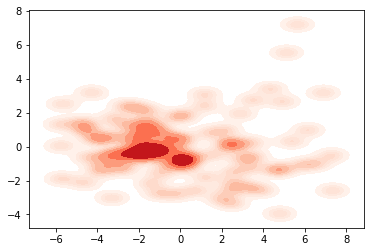

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -134819.71840604447
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -118996.68305985612
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -102416.19978610985
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -86804.88814080262
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -67583.58032449742
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -52242.25530346422
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -26097.644240897178
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -10950.26059580117
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 14909.117182231392
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -134819.71840604447
INFO:Main:For label 45 log_p_gm_diag = 74474.4414088843
INFO:Main:For label 45 log_p_gaus_diag = 77616.90620070402
INFO:Main:For label 45 rel_diff =         -0.04048

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_60 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


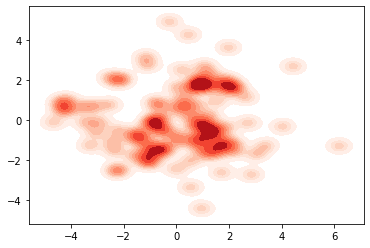

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -151060.4400623981
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -137578.64961961
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -121110.9836419945
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -99163.31498558936
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -85822.80310487654
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -66900.30396717676
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -48278.30017539079
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -28614.179353732558
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -7869.833912252332
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -151060.4400623981
INFO:Main:For label 46 log_p_gm_diag = 85863.91695612615
INFO:Main:For label 46 log_p_gaus_diag = 91547.13120345175
INFO:Main:For label 46 rel_diff =         -0.06207965
I

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_61 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_122 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


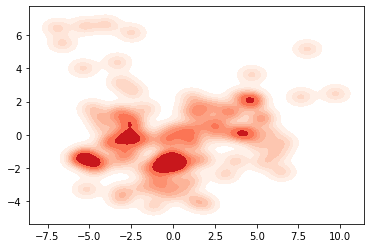

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -105863.54821785804
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -94037.87504594095
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -78617.42717483279
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -59783.20488387221
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -39179.93222264922
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -18796.116738839744
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 7689.262220188655
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 12552.99633088967
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 53172.92296355488
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -105863.54821785804
INFO:Main:For label 47 log_p_gm_diag = 55342.53851822256
INFO:Main:For label 47 log_p_gaus_diag = 64467.242682166005
INFO:Main:For label 47 rel_diff =         -0.14154016

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_62 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_124 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


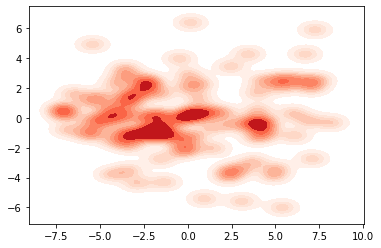

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -87760.59524537702
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -70891.64481320058
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -51163.322855566046
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -35894.25979328793
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -12393.632922643475
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = 10059.008420998376
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 26184.392284473404
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 39265.24153191311
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 60168.4861283543
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -87760.59524537702
INFO:Main:For label 48 log_p_gm_diag = 51844.75693582285
INFO:Main:For label 48 log_p_gaus_diag = 51826.49400024426
INFO:Main:For label 48 rel_diff =         0.00035239
IN

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_63 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


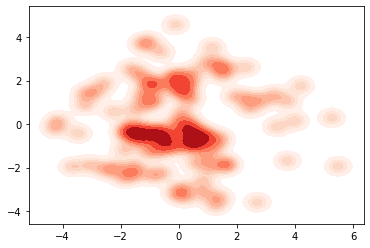

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -170387.6279276737
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -152047.08666743606
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -138022.36716611765
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -123512.3294708918
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -102918.75021328841
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -88967.03132669878
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -66510.61769029833
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -50744.74511922593
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -39721.9968866079
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -170387.6279276737
INFO:Main:For label 49 log_p_gm_diag = 101789.99844330396
INFO:Main:For label 49 log_p_gaus_diag = 99676.87320869621
INFO:Main:For label 49 rel_diff =         0.0211997

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_64 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


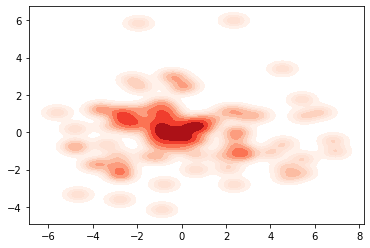

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -169351.18634087231
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -157096.60695866036
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -139613.21212695958
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -121733.53225888865
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -106355.56929771506
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -79248.26802381
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -70528.86504117982
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -46661.42876699829
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -40098.440670910786
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -169351.18634087231
INFO:Main:For label 50 log_p_gm_diag = 101978.2203354554
INFO:Main:For label 50 log_p_gaus_diag = 93620.84681173119
INFO:Main:For label 50 rel_diff =         0.089268

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_65 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_130 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


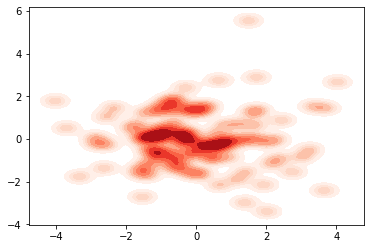

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -157670.49754943926
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -138186.03629176816
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -121195.72856021015
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -104762.96231798979
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -84023.40467419737
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -70273.02378508466
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -47892.05450813769
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -33426.129691331706
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -14076.397894831083
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -157670.49754943926
INFO:Main:For label 51 log_p_gm_diag = 88967.19894741554
INFO:Main:For label 51 log_p_gaus_diag = 93151.51011417275
INFO:Main:For label 51 rel_diff =         -0.04

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_66 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_132 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


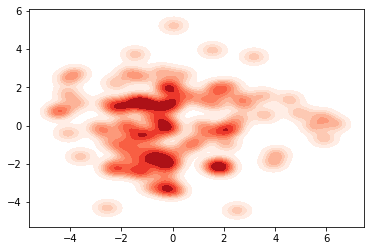

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -147053.8350022971
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -130063.47796618927
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -114100.24525952796
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -101711.75798358396
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -83281.86915904537
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -63263.5330476347
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -33654.828258652706
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -12446.492957057897
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 8028.640128980245
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -147053.8350022971
INFO:Main:For label 52 log_p_gm_diag = 77914.67993550988
INFO:Main:For label 52 log_p_gaus_diag = 88814.97899158049
INFO:Main:For label 52 rel_diff =         -0.122730

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_67 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_134 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


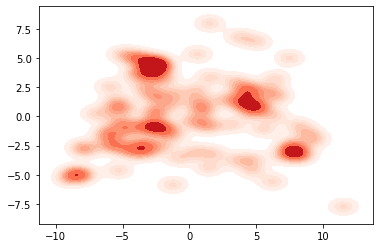

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -75471.93032084762
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -63760.31408290114
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -44824.552529885244
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -27291.313849821367
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -6631.412679607631
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = 44.91390042298008
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 18745.941417638736
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 41930.93954821379
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 59151.61784761118
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -75471.93032084762
INFO:Main:For label 53 log_p_gm_diag = 52353.19107619441
INFO:Main:For label 53 log_p_gaus_diag = 45322.12966010164
INFO:Main:For label 53 rel_diff =         0.15513528
IN

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_68 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_136 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


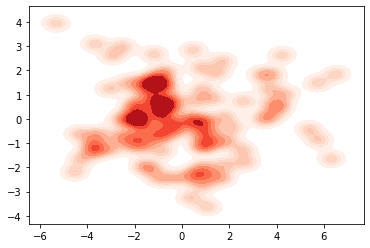

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -154811.9161841151
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -136582.51495046524
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -127857.58581467636
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -105863.45838387683
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -92667.85287630983
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -68846.28863136825
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -49251.99307688279
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -35439.86093382281
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -7288.230858262134
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -154811.9161841151
INFO:Main:For label 54 log_p_gm_diag = 85573.11542913107
INFO:Main:For label 54 log_p_gaus_diag = 88085.24246943831
INFO:Main:For label 54 rel_diff =         -0.028519

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_138 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_69 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_138 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


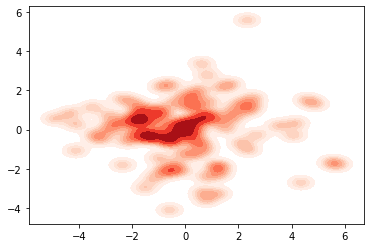

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -164455.53726474757
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -146289.13874186337
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -129115.7328034598
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -106579.35312725377
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -96897.97783952294
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -78071.04896014434
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -66387.12125742147
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -36026.34820689162
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -25680.444261020602
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -164455.53726474757
INFO:Main:For label 55 log_p_gm_diag = 94769.2221305103
INFO:Main:For label 55 log_p_gaus_diag = 95047.30409890303
INFO:Main:For label 55 rel_diff =         -0.00292

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_70 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_140 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


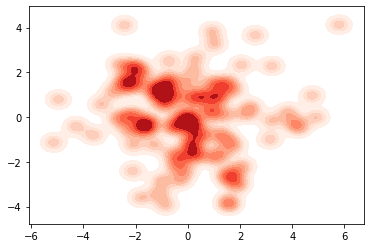

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -149125.9417128973
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -144034.52169632784
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -119866.63198356613
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -105868.53586612933
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -88369.48755725235
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -71688.31700796724
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -51567.059431877395
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -31307.615423472133
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -16241.06019036827
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -149125.9417128973
INFO:Main:For label 56 log_p_gm_diag = 90049.53009518412
INFO:Main:For label 56 log_p_gaus_diag = 90554.16542443521
INFO:Main:For label 56 rel_diff =         -0.0055

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_142 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_71 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_142 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


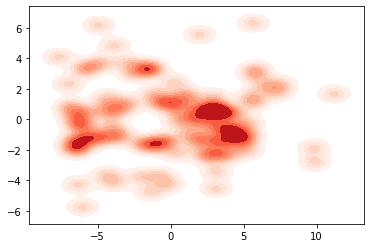

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -109291.2297524343
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -92136.92843812343
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -78901.08594141141
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -55651.49420439222
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -36586.334195876756
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -23433.644511231687
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -2730.984319258685
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 14505.928213376843
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 36485.84019085101
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -109291.2297524343
INFO:Main:For label 57 log_p_gm_diag = 63686.079904574486
INFO:Main:For label 57 log_p_gaus_diag = 62395.5052723655
INFO:Main:For label 57 rel_diff =         0.02068378


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_72 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_144 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


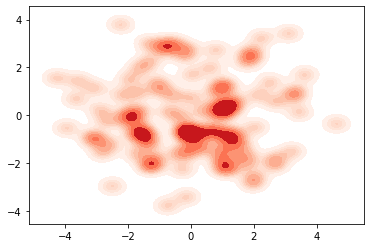

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -156146.15726036974
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -138078.32082255877
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -120477.21648539382
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -104319.1546098147
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -82457.05621304963
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -66989.54499694903
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -47679.29229069318
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -30877.98862183455
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -9218.919046807918
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -156146.15726036974
INFO:Main:For label 58 log_p_gm_diag = 86538.45952340396
INFO:Main:For label 58 log_p_gaus_diag = 94317.20049710432
INFO:Main:For label 58 rel_diff =         -0.08247

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_73 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_146 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


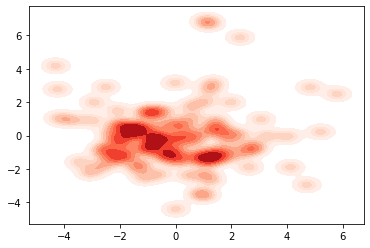

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -152327.4120288071
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -133643.38848277947
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -119346.28944680712
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -101099.12014862223
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -80384.9528444637
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -60943.33981954504
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -43662.29515210865
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -23183.642488072917
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -13309.938234361936
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -152327.4120288071
INFO:Main:For label 59 log_p_gm_diag = 88583.96911718097
INFO:Main:For label 59 log_p_gaus_diag = 92203.34644689599
INFO:Main:For label 59 rel_diff =         -0.03925

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_74 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_148 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


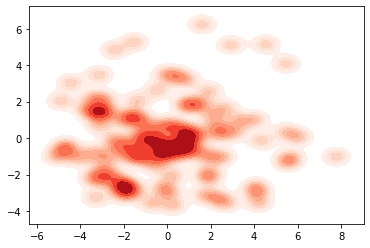

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -152883.94489977555
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -147659.8570350186
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -121898.89198864053
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -105978.0582907098
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -81378.58620159395
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -84900.19082528213
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -62319.96609877309
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -42422.9924471518
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -22535.583873254014
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -152883.94489977555
INFO:Main:For label 60 log_p_gm_diag = 93196.79193662702
INFO:Main:For label 60 log_p_gaus_diag = 89215.82376156043
INFO:Main:For label 60 rel_diff =         0.0446217

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_75 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_150 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


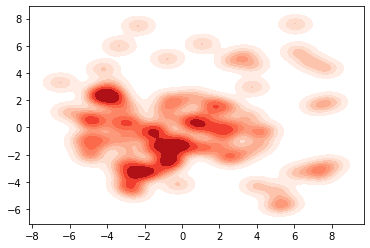

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -133111.343541298
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -123652.46390112618
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -101919.56132166507
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -84722.95239005407
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -68405.56512770243
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -56087.981528011675
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -33089.86918726569
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -9948.788069514645
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 11948.72312330635
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -133111.343541298
INFO:Main:For label 61 log_p_gm_diag = 75954.63843834682
INFO:Main:For label 61 log_p_gaus_diag = 73211.81697433667
INFO:Main:For label 61 rel_diff =         0.03746419
I

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_76 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_152 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


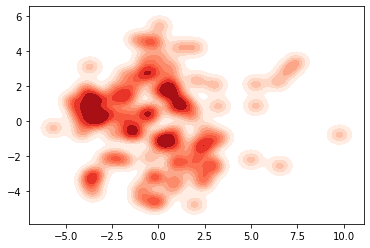

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -117876.46241621336
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -104781.85691271606
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -83809.92921711033
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -69595.70272702776
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -51172.624728572526
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -25948.105328679172
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -19765.838630797924
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -1068.5433191981283
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 26304.647463999805
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -117876.46241621336
INFO:Main:For label 62 log_p_gm_diag = 68776.6762680001
INFO:Main:For label 62 log_p_gaus_diag = 70624.34534209734
INFO:Main:For label 62 rel_diff =         -0.026

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_77 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_154 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


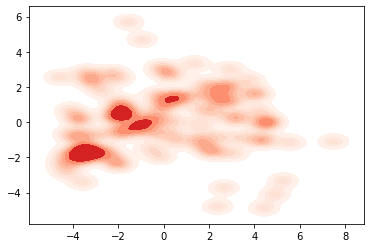

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -119288.25156492551
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -110896.90826972644
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -105604.34336674609
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -84324.09601895124
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -71323.57282889192
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -50950.889580369956
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -14931.13682660868
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -13480.776302166312
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 8803.257964208518
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -119288.25156492551
INFO:Main:For label 63 log_p_gm_diag = 77527.37101789574
INFO:Main:For label 63 log_p_gaus_diag = 76357.8431458222
INFO:Main:For label 63 rel_diff =         0.015316

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_156 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_78 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_156 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


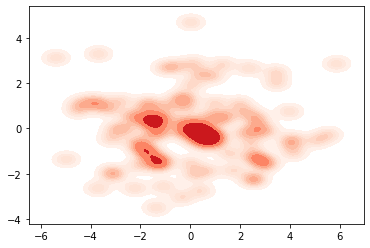

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -137500.4140094873
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -119176.25164284301
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -105194.77615079319
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -80437.72613260831
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -67620.58116066016
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -43602.17663552522
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -33212.026405167446
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -9218.42784850736
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -277.7814849719289
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -137500.4140094873
INFO:Main:For label 64 log_p_gm_diag = 82067.89074248596
INFO:Main:For label 64 log_p_gaus_diag = 82169.95080379154
INFO:Main:For label 64 rel_diff =         -0.0012420

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_158 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_79 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_158 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


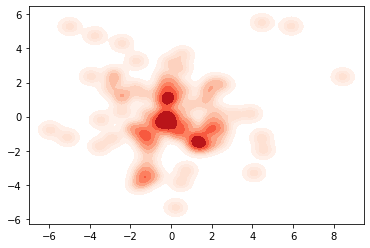

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -140048.30991681854
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -124931.41078376482
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -111827.91549137473
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -93079.03916529345
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -67409.2577564015
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -52482.530148930324
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -32553.852384567406
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -23989.558542980085
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 5079.693398120056
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -140048.30991681854
INFO:Main:For label 65 log_p_gm_diag = 79389.15330093997
INFO:Main:For label 65 log_p_gaus_diag = 84517.49882949376
INFO:Main:For label 65 rel_diff =         -0.0606

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_80 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_160 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


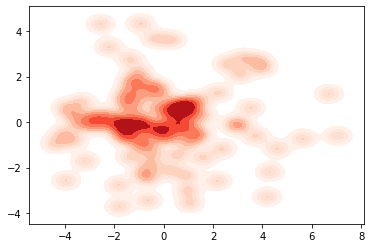

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -134483.2953653127
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -114552.45175700838
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -92948.93685309132
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -79465.03073537454
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -61605.70750883958
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -37565.20112944464
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -22882.208853245887
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -7513.660429245298
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 15576.355438110244
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -134483.2953653127
INFO:Main:For label 66 log_p_gm_diag = 74140.82228094488
INFO:Main:For label 66 log_p_gaus_diag = 81080.2126925385
INFO:Main:For label 66 rel_diff =         -0.08558673

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_81 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_162 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


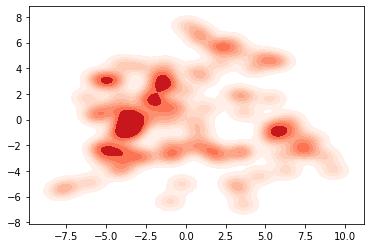

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -117284.81047088146
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -108178.02348484282
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -79652.74449268452
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -69993.8711926874
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -51942.43081718302
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -39746.83464528766
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -18251.46938619099
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -10904.949975293013
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 22521.898462828598
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -117284.81047088146
INFO:Main:For label 67 log_p_gm_diag = 70668.0507685857
INFO:Main:For label 67 log_p_gaus_diag = 65676.46058667307
INFO:Main:For label 67 rel_diff =         0.07600273

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_82 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_164 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


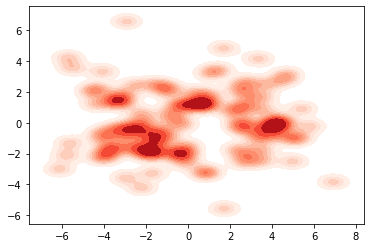

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -127052.77370366946
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -107860.37064887633
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -95535.83028163342
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -73369.46729043737
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -53192.88557401975
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -36979.50164188593
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -6558.038866239629
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -3367.2951541979855
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 19191.098527567112
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -127052.77370366946
INFO:Main:For label 68 log_p_gm_diag = 72333.45073621644
INFO:Main:For label 68 log_p_gaus_diag = 74383.54429892452
INFO:Main:For label 68 rel_diff =         -0.02756

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_83 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_166 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


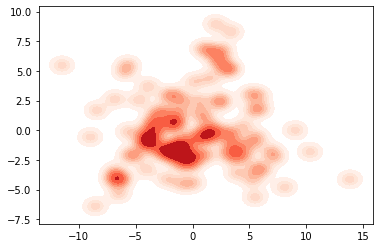

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -91106.7167271587
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -85663.23723957755
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -64217.33917337877
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -48318.92169947724
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -38279.19907844416
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -8593.829596368727
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 3176.094733315229
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 22930.924148842023
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 23206.845552034007
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -91106.7167271587
INFO:Main:For label 69 log_p_gm_diag = 70325.577223983
INFO:Main:For label 69 log_p_gaus_diag = 59550.51032178491
INFO:Main:For label 69 rel_diff =         0.18093996
INFO:M

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_84 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_168 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


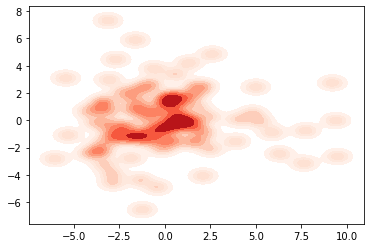

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -137181.37710624054
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -123376.41508397978
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -108010.7935930966
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -92911.60084362066
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -74156.84773884094
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -58240.32573106536
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -40797.670823186636
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -25899.793801893888
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -8061.490827940172
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -137181.37710624054
INFO:Main:For label 70 log_p_gm_diag = 85959.74541397009
INFO:Main:For label 70 log_p_gaus_diag = 83545.57819017826
INFO:Main:For label 70 rel_diff =         0.02889

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_85 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_170 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


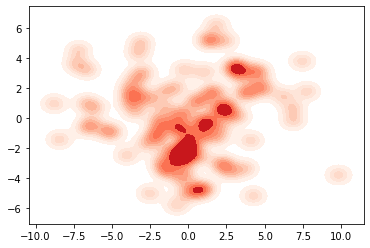

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -142373.0695869915
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -136390.43075045163
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -119321.66706610972
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -105472.34122457082
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -91663.01520767767
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -70214.25090959173
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -64443.43876176124
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -45811.642373644805
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -23070.927849974658
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -142373.0695869915
INFO:Main:For label 71 log_p_gm_diag = 93464.46392498731
INFO:Main:For label 71 log_p_gaus_diag = 80509.02774393046
INFO:Main:For label 71 rel_diff =         0.16091

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_86 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_172 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


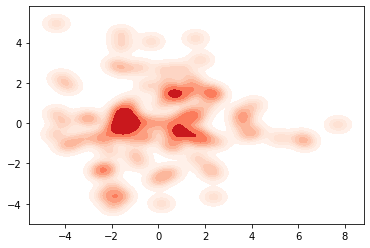

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -134385.77454867127
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -119992.49299648558
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -101971.63101534694
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -82296.22213096402
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -64174.08301931995
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -50985.72389639297
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -34257.13193890004
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -18951.190275112283
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -2290.104121290962
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -134385.77454867127
INFO:Main:For label 72 log_p_gm_diag = 83074.05206064548
INFO:Main:For label 72 log_p_gaus_diag = 80720.82959478622
INFO:Main:For label 72 rel_diff =         0.02915

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_87 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_174 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


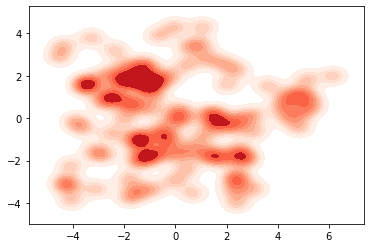

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -154633.58213742625
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -135317.10288653267
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -122309.02643022669
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -113862.29844452534
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -90142.57555792533
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -74563.75847450341
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -40764.31479485537
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -32713.15606887429
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -13728.794920528162
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -154633.58213742625
INFO:Main:For label 73 log_p_gm_diag = 88793.39746026408
INFO:Main:For label 73 log_p_gaus_diag = 90185.97475611852
INFO:Main:For label 73 rel_diff =         -0.015

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_88 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_176 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


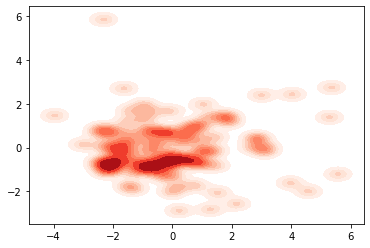

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -204907.1629370188
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -190322.5286972494
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -174061.7302442523
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -155434.6252443672
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -136477.79496446985
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -116455.38882860434
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -100385.03238252876
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -83958.61218014127
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -68367.2862001296
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -204907.1629370188
INFO:Main:For label 74 log_p_gm_diag = 116112.6431000648
INFO:Main:For label 74 log_p_gaus_diag = 113228.03939774507
INFO:Main:For label 74 rel_diff =         0.0254760

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_89 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_178 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


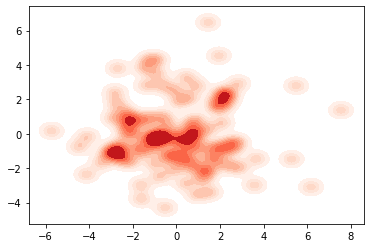

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -114665.34374992218
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -103131.42276828334
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -84286.43186702378
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -67732.68667044526
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -54389.536121195386
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -40659.303086862
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -19761.479966629966
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -797.678363996296
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 15061.884323316044
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -114665.34374992218
INFO:Main:For label 75 log_p_gm_diag = 74398.05783834198
INFO:Main:For label 75 log_p_gaus_diag = 73725.81697800178
INFO:Main:For label 75 rel_diff =         0.00911812

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_90 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_180 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


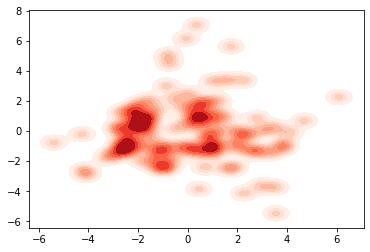

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -143743.6589297684
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -128765.48759092554
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -110360.65441802298
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -89580.4048212372
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -74467.23833005875
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -57747.62787518036
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -39918.23236195679
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -14735.409916256613
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -4738.962413919857
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -143743.6589297684
INFO:Main:For label 76 log_p_gm_diag = 84298.48120695993
INFO:Main:For label 76 log_p_gaus_diag = 86412.99907344447
INFO:Main:For label 76 rel_diff =         -0.0244699

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_91 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_182 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


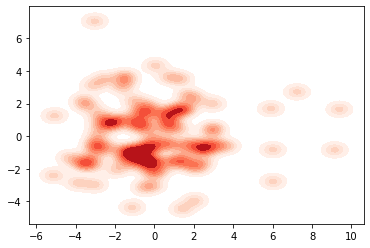

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -120988.59721728577
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -101156.0315731839
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -88373.23959551426
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -72030.56554087426
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -49910.28385297366
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -34228.17275376056
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -10479.165637313097
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -4399.038592859346
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 18371.804933963576
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -120988.59721728577
INFO:Main:For label 77 log_p_gm_diag = 72743.09753301821
INFO:Main:For label 77 log_p_gaus_diag = 74835.7908047228
INFO:Main:For label 77 rel_diff =         -0.0279638

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_92 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_184 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


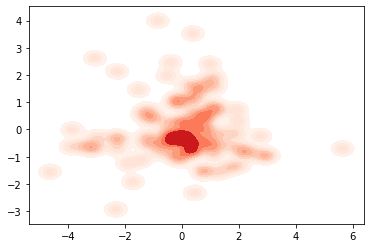

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -211694.99498650176
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -193872.4675300666
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -176220.057069987
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -157528.306260773
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -147610.5628504207
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -135016.28036899157
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -113236.2163164459
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -97692.44827373399
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -84505.8635742541
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -211694.99498650176
INFO:Main:For label 78 log_p_gm_diag = 124181.93178712705
INFO:Main:For label 78 log_p_gaus_diag = 120862.02976293323
INFO:Main:For label 78 rel_diff =         0.02746853

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_93 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_187 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


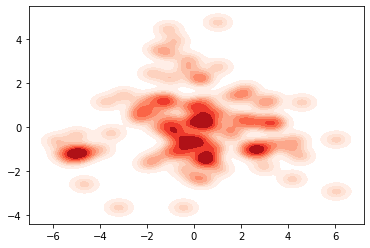

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -199825.3401023736
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -181646.27243348377
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -178913.36148777592
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -169713.7107193928
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -139018.57327257568
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -131131.5723834416
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -115909.59090834943
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -94750.28568394089
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -77367.00770771125
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -199825.3401023736
INFO:Main:For label 79 log_p_gm_diag = 120612.50385385564
INFO:Main:For label 79 log_p_gaus_diag = 108454.49375029874
INFO:Main:For label 79 rel_diff =         0.1121

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_94 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_188 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


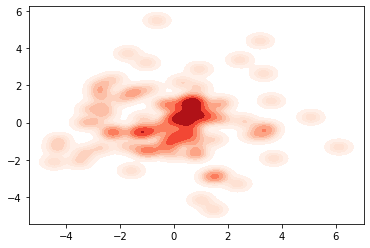

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -164252.49503450416
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -147671.81432136887
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -128035.3468651172
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -113175.83430947363
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -91588.86960782297
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -77752.41127310618
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -57041.040882225265
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -40777.635989672825
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -29876.714799541427
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -164252.49503450416
INFO:Main:For label 80 log_p_gm_diag = 96867.35739977071
INFO:Main:For label 80 log_p_gaus_diag = 95076.01300441346
INFO:Main:For label 80 rel_diff =         0.018

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_95 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_190 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_191 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


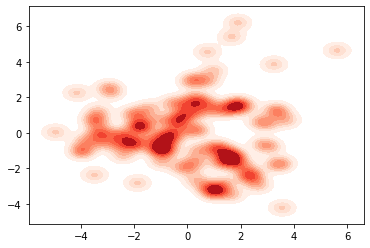

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -121682.46806265175
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -108561.2251882292
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -91926.98852123637
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -76628.98238147804
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -56152.44655014528
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -37106.21087411829
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -18747.032024620683
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -4966.3102801181085
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 17182.34250679685
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -121682.46806265175
INFO:Main:For label 81 log_p_gm_diag = 73337.82874660158
INFO:Main:For label 81 log_p_gaus_diag = 77344.61669748982
INFO:Main:For label 81 rel_diff =         -0.051804

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_96 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_192 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


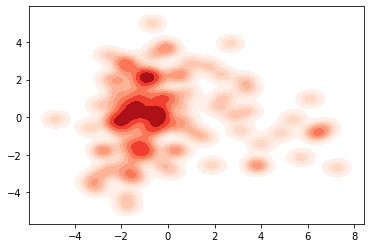

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -136996.96013853967
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -126617.56113189529
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -109720.52157681793
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -89126.12526608605
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -71068.03698693877
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -51583.308540813276
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -41368.781715545454
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -25551.249359662324
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -476.2425322224735
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -136996.96013853967
INFO:Main:For label 82 log_p_gm_diag = 82167.12126611124
INFO:Main:For label 82 log_p_gaus_diag = 83262.36885500481
INFO:Main:For label 82 rel_diff =         -0.01

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_194 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_97 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_194 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


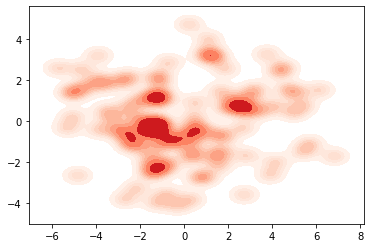

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -139150.04345334801
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -126346.40883104265
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -108348.0444309377
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -84877.22322245841
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -76038.6841821585
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -57352.53360572457
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -34917.22408519586
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -16501.65093116826
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -520.4930443257617
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -139150.04345334801
INFO:Main:For label 83 log_p_gm_diag = 82189.24652216288
INFO:Main:For label 83 log_p_gaus_diag = 81876.03555146448
INFO:Main:For label 83 rel_diff =         0.00382543

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_98 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_196 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


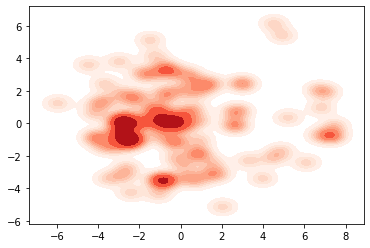

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -140220.9879895501
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -124689.9742973375
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -107396.42699991248
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -94284.38126603203
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -77198.04460330767
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -58993.213849541324
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -31306.649493361503
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -18438.341359238024
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -6021.719310401066
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -140220.9879895501
INFO:Main:For label 84 log_p_gm_diag = 84939.85965520053
INFO:Main:For label 84 log_p_gaus_diag = 81501.11384042025
INFO:Main:For label 84 rel_diff =         0.042192

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_198 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_99 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_198 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


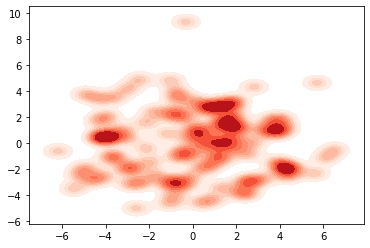

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -103301.48390863813
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -90498.44217978226
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -70277.01343137256
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -55367.00693725518
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -30178.370946782292
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -14778.330005816155
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 4538.802322470656
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 21618.2643910888
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 44242.84017799595
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -103301.48390863813
INFO:Main:For label 85 log_p_gm_diag = 59807.57991100202
INFO:Main:For label 85 log_p_gaus_diag = 65646.11878117226
INFO:Main:For label 85 rel_diff =         -0.08893959


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_200 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_100 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_200 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


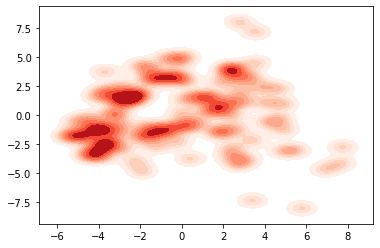

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -109591.1533734409
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -92461.80960170232
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -82231.37779285459
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -63641.51372272725
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -49576.830866902834
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -23428.50535246695
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -16601.775859712216
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 4064.9306977265805
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 21483.841509525868
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -109591.1533734409
INFO:Main:For label 86 log_p_gm_diag = 71187.07924523707
INFO:Main:For label 86 log_p_gaus_diag = 64914.58927689225
INFO:Main:For label 86 rel_diff =         0.09662681

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_202 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_101 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_202 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


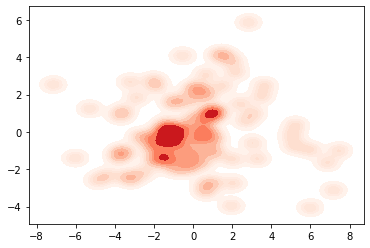

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -139861.65192497917
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -124936.25186437188
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -109675.24705631743
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -96008.87091473633
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -73947.98968920484
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -56981.66357529588
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -28911.953203208395
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -9261.274743712653
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 1774.0319445537752
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -139861.65192497917
INFO:Main:For label 87 log_p_gm_diag = 81041.98402772311
INFO:Main:For label 87 log_p_gaus_diag = 79617.517538769
INFO:Main:For label 87 rel_diff =         0.0178913

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_204 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_102 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_204 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_205 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


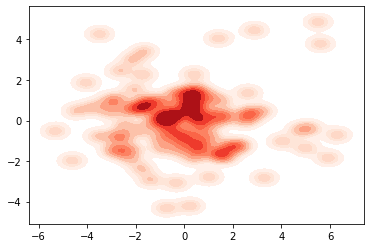

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -131530.0261545501
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -116688.3842639862
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -95628.9716819794
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -81710.55320622626
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -65622.02505801481
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -42663.03790504471
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -24774.0031220557
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -9172.5096173622
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 8544.983333417855
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -131530.0261545501
INFO:Main:For label 88 log_p_gm_diag = 77656.50833329107
INFO:Main:For label 88 log_p_gaus_diag = 77799.85288149344
INFO:Main:For label 88 rel_diff =         -0.00184248
INFO:

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_103 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_206 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_207 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


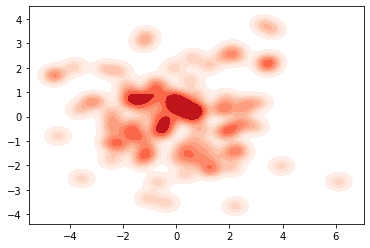

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -145729.77288270908
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -132605.78071656462
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -116997.89501039009
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -96754.77519337583
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -81191.9476845706
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -57425.02811269878
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -48586.23484407825
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -28460.461499251076
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -4760.654316151456
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -145729.77288270908
INFO:Main:For label 89 log_p_gm_diag = 84309.32715807573
INFO:Main:For label 89 log_p_gaus_diag = 89720.13161580086
INFO:Main:For label 89 rel_diff =         -0.06030

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_104 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_208 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_209 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


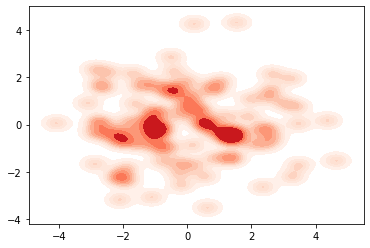

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -157638.13509075798
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -140535.26314953004
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -123564.58543157513
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -105733.0913686271
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -87848.53679114117
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -69022.04042256693
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -49288.748924258165
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -31088.774090427964
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -14893.896109803754
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -157638.13509075798
INFO:Main:For label 90 log_p_gm_diag = 89375.94805490188
INFO:Main:For label 90 log_p_gaus_diag = 93133.02151966646
INFO:Main:For label 90 rel_diff =         -0.04

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_210 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_105 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_210 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


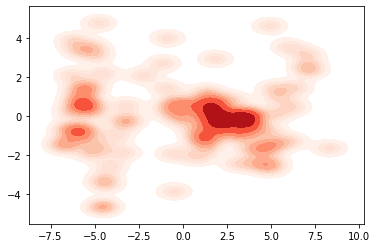

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -144877.28600473038
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -123042.4721023385
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -111634.1566355562
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -94107.13615901605
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -77209.99533595017
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -54815.37286494885
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -36140.67772655573
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -16372.997067242744
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 986.2065173057781
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -144877.28600473038
INFO:Main:For label 91 log_p_gm_diag = 81435.89674134711
INFO:Main:For label 91 log_p_gaus_diag = 75199.57043932907
INFO:Main:For label 91 rel_diff =         0.08293034

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_212 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_106 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_212 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_213 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


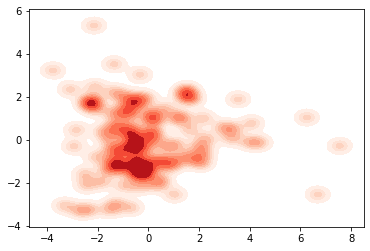

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -152732.45161884947
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -145592.52195010864
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -123448.97233351172
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -103539.05369776429
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -84842.82571244112
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -69968.61780482638
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -62968.39398979288
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -43357.16702520772
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -28189.771156362956
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -152732.45161884947
INFO:Main:For label 92 log_p_gm_diag = 96023.88557818146
INFO:Main:For label 92 log_p_gaus_diag = 92458.20388905989
INFO:Main:For label 92 rel_diff =         0.0385

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_214 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_107 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_214 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_215 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


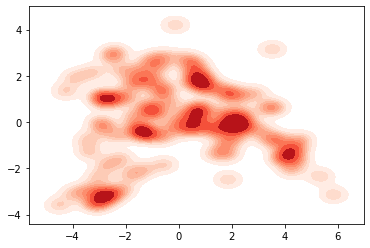

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -172155.90626425116
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -139391.38197764615
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -144866.71564897493
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -131184.80890004424
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -108654.8796549057
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -92502.58465685142
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -80000.3371363674
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -46657.075286863546
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -33843.01709193623
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -172155.90626425116
INFO:Main:For label 93 log_p_gm_diag = 98850.50854596811
INFO:Main:For label 93 log_p_gaus_diag = 93483.89872825531
INFO:Main:For label 93 rel_diff =         0.05740

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_108 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_216 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


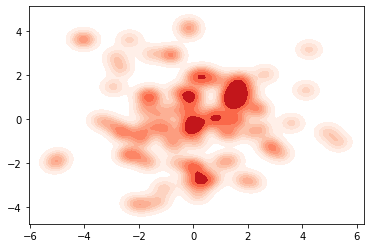

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -176285.52003998897
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -163938.0838829567
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -146309.66547503846
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -126828.6344732877
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -107379.73026167101
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -89660.87834059348
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -70447.81244498116
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -59861.456879841746
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -36133.43332709384
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -176285.52003998897
INFO:Main:For label 94 log_p_gm_diag = 99995.71666354692
INFO:Main:For label 94 log_p_gaus_diag = 102481.91738049251
INFO:Main:For label 94 rel_diff =         -0.024

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_218 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_109 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_218 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_219 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


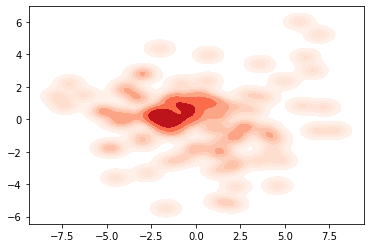

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -124994.31977112009
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -108534.38887155606
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -93088.85281242937
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -79225.36696775779
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -58661.69972910412
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -42024.250316464924
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -24009.563752982212
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 1466.5043428471545
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 13673.624335745582
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -124994.31977112009
INFO:Main:For label 95 log_p_gm_diag = 75092.18783212721
INFO:Main:For label 95 log_p_gaus_diag = 74666.43841824983
INFO:Main:For label 95 rel_diff =         0.00570

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_110 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_220 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_221 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


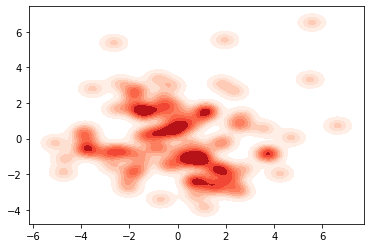

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -148666.8365746144
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -130037.37980245054
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -114192.10380792894
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -99357.77564417047
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -82888.52787510568
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -61071.975756489
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -46816.743020766095
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -16887.827079867973
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -49.872559296520194
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -148666.8365746144
INFO:Main:For label 96 log_p_gm_diag = 81953.93627964826
INFO:Main:For label 96 log_p_gaus_diag = 87661.28310145688
INFO:Main:For label 96 rel_diff =         -0.065106

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_222 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_111 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_222 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


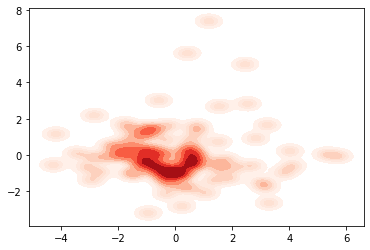

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -165072.12185367633
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -148464.05790935594
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -132014.71607657138
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -118540.66247648868
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -98175.848183989
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -80108.60282062477
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -63969.51073577051
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -41324.6154510958
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -18920.85897043071
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -165072.12185367633
INFO:Main:For label 97 log_p_gm_diag = 91389.42948521535
INFO:Main:For label 97 log_p_gaus_diag = 98720.47491318287
INFO:Main:For label 97 rel_diff =         -0.0742606

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_224 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_112 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_224 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


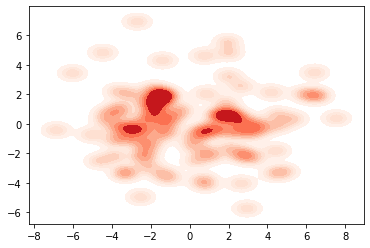

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -98720.93144569249
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -79174.30398812468
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -61431.31779089925
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -45797.037704089904
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -29761.535235643998
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -4025.3899814030156
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = 6845.247803568738
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = 21036.12953066759
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = 50219.310361734126
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -98720.93144569249
INFO:Main:For label 98 log_p_gm_diag = 56819.34481913294
INFO:Main:For label 98 log_p_gaus_diag = 59701.695139624004
INFO:Main:For label 98 rel_diff =         -0.0482792

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_226 (Conv2D)          (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_227 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_113 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_226 (Dense)            (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_227 (Dense)            (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


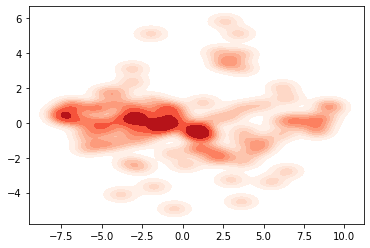

INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -156950.56147579453
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -136268.33607766568
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -126750.6279462889
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -106663.56016538292
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -80840.35885673424
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -74477.51084140653
INFO:calc_z_likelihood:Built GM model with k = 8 and test aic = -60196.94598143603
INFO:calc_z_likelihood:Built GM model with k = 9 and test aic = -8646.146355655306
INFO:calc_z_likelihood:Built GM model with k = 10 and test aic = -38396.23733292587
INFO:calc_z_likelihood:best gm model with k = 2 and test aic = -156950.56147579453
INFO:Main:For label 99 log_p_gm_diag = 101127.11866646293
INFO:Main:For label 99 log_p_gaus_diag = 82845.86965980897
INFO:Main:For label 99 rel_diff =         0.22066

In [16]:
# Main snippet for Z posterior estimation via boostrapping
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('Main')
caes = dict()
train_labels2 = np.transpose(train_labels)[0]
test_labels2 = np.transpose(test_labels)[0]
labels_logps_dict = dict()
unique_labels = np.unique(train_labels)
for label in unique_labels:
    train_idx = train_labels2==label
    test_idx = test_labels2 == label
    
    train_images_label = train_images[train_idx,:,:]
    test_images_label = test_images[test_idx,:,:]

    logger.info(f'Training autoencoder for label {label}')
    caes[label]  = CAE(latent_dim)
    caes[label].compile(optimizer='adam', loss=losses.MeanSquaredError())
    caes[label].fit(train_images_label, train_images_label,
                epochs=10,
                shuffle=True,
                batch_size=batch_size,
                validation_data=(test_images_label, test_images_label))
    
    z = caes[label].encoder(test_images_label)
    if z.shape[0] >2:
        logger.info('Apply PCA for 2D plot of Z')
        s = StandardScaler()
        z_scaled = s.fit(z)
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)
        z1 = z_pca[:,0]
        z2 = z_pca[:,1]
    elif z.shape[0] == 2:
        z1 = z[:,0].numpy()
        z2 = z[:,1].numpy()
    else:
        raise ValueError('Z shape must be >=2')
    sns.kdeplot(pd.Series(z1), pd.Series(z2), cmap="Reds", shade=True, bw=.15)
    plt.show()
    
    logps = calc_z_likelihood(z=z)
    logger.info(f"""For label {label} log_p_gm_diag = {logps['GM_diag']}""")
    logger.info(f"""For label {label} log_p_gaus_diag = {logps['Gaus_diag']}""")
    diff = logps['GM_diag'] - logps['Gaus_diag']
    rel_diff = np.round(diff/np.abs(logps['Gaus_diag']),8)
    logger.info(f"""For label {label} rel_diff = \
        {rel_diff}""")
    
    entry = {'log_p_gm_diag':logps['GM_diag'],'log_p_gaus_diag':logps['Gaus_diag'],\
             'rel_diff': rel_diff }
    labels_logps_dict[label] = entry
    
    

In [17]:
labels_logps_dict

{0: {'log_p_gm_diag': 71329.33298454604,
  'log_p_gaus_diag': 66241.02183439283,
  'rel_diff': 0.07681511},
 1: {'log_p_gm_diag': 84128.9199067496,
  'log_p_gaus_diag': 85207.20115667897,
  'rel_diff': -0.01265481},
 2: {'log_p_gm_diag': 92078.89544916498,
  'log_p_gaus_diag': 95920.69109502962,
  'rel_diff': -0.04005179},
 3: {'log_p_gm_diag': 79997.7496854664,
  'log_p_gaus_diag': 85892.13635538048,
  'rel_diff': -0.06862545},
 4: {'log_p_gm_diag': 107266.07517292807,
  'log_p_gaus_diag': 113199.58190983906,
  'rel_diff': -0.05241633},
 5: {'log_p_gm_diag': 80256.4533508038,
  'log_p_gaus_diag': 85015.70794771507,
  'rel_diff': -0.05598089},
 6: {'log_p_gm_diag': 82100.49376047996,
  'log_p_gaus_diag': 82188.70849098965,
  'rel_diff': -0.00107332},
 7: {'log_p_gm_diag': 128006.98584623194,
  'log_p_gaus_diag': 124025.74920958906,
  'rel_diff': 0.03210008},
 8: {'log_p_gm_diag': 103001.50469800085,
  'log_p_gaus_diag': 98045.97200654763,
  'rel_diff': 0.05054295},
 9: {'log_p_gm_diag'

In [19]:
# calculate average relative improvment in sum-log-likelihood
rel_diff_list = [val['rel_diff'] for key,val in labels_logps_dict.items()]
pd.Series(rel_diff_list).describe()

count    100.000000
mean      -0.004056
std        0.074969
min       -0.177554
25%       -0.051957
50%       -0.010281
75%        0.027825
max        0.220666
dtype: float64